<a href="https://colab.research.google.com/github/juurie/Projects/blob/main/%EC%A0%9C%EC%A3%BC%EB%8F%84_%EB%8F%84%EB%A1%9C_%EA%B5%90%ED%86%B5%EB%9F%89_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import package

In [ ]:
import requests
import xmltodict,json
from urllib.parse import urlencode, unquote, quote_plus
import re
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import seaborn as sns
import networkx as nx
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
import folium
import plotly.graph_objects as go
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import plotly.express as px
import cufflinks as cf
cf.go_offline(connected=True)
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression,chi2, SelectKBest
#from sklearn.feature_selection import chi2, SelectKBest

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# load data

In [ ]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [ ]:
train["date"] = pd.to_datetime(train["base_date"],format='%Y%m%d')
train['year']= train['date'].dt.year
train['month']= train['date'].dt.month
train['day']= train['date'].dt.day
test

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,TEST_291236,20220827,토,5,1,103,일반국도16호선,0,0,80.0,...,0.0,0,월산마을,33.472819,126.463030,없음,도근교,33.470483,126.460846,없음
291237,TEST_291237,20220819,금,20,2,103,일반국도11호선,0,0,60.0,...,0.0,0,영주교,33.305359,126.598914,없음,하례입구삼거리,33.300796,126.600332,없음
291238,TEST_291238,20220805,금,11,1,107,신대로,0,0,30.0,...,0.0,0,마리나사거리,33.493624,126.496769,있음,칠오광장사거리,33.497500,126.496946,있음
291239,TEST_291239,20220812,금,7,2,107,경찰로,0,0,60.0,...,0.0,0,국민의료보험관리공단,33.254782,126.507014,없음,의료보험조합,33.255659,126.507333,없음


# scaling

In [ ]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

In [ ]:
data = train.drop(['id','date','road_name', 'vehicle_restricted', 'height_restricted', 'start_node_name', 'end_node_name'], axis=1)
d_test = test.drop(['id','road_name', 'vehicle_restricted', 'height_restricted','start_node_name', 'end_node_name'], axis=1)

In [ ]:
mean = data.mean(axis=0)
data -= mean # 평균을 빼고
std = data.std(axis=0)
data /= std # 표준편차로 나누어 줌

# 테스트 데이터가 아닌 훈련용 데이터에서 구한 평균과 표준편차를 이용하여 정규화를 해줌
d_test -= mean 
d_test /= std

d_train = data.drop('target', axis=1)
d_target = train["target"]

# data split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_train, d_target, random_state=0)

x_train.shape
x_test.shape
y_train.shape
y_test.shape
#x_train

(3525912, 19)

(1175305, 19)

(3525912,)

(1175305,)

# select feautre

## SelectKBest

In [ ]:
## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=10)

## 학습데이터에 fit_transform 
x_train_selected = selector.fit_transform(x_train, y_train)

## 테스트 데이터는 transform
x_test_selected = selector.transform(x_test)
x_train_selected.shape, x_test_selected.shape

((3525912, 10), (1175305, 10))

In [ ]:
all_names = x_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성(변수)들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성(변수)들
unselected_names = all_names[~selected_mask]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['base_hour', 'lane_count', 'road_rating', 'connect_code',
       'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_latitude', 'start_turn_restricted', 'end_turn_restricted'],
      dtype='object')
Unselected names:  Index(['base_date', 'day_of_week', 'multi_linked', 'start_longitude',
       'end_latitude', 'end_longitude', 'year', 'month', 'day'],
      dtype='object')


In [ ]:
x_train = DataFrame(x_train, columns = selected_names)

x_test = DataFrame(x_test, columns = selected_names)

d_test = DataFrame(d_test, columns = selected_names)
d_test.shape

(291241, 10)

# Mechine learning

## lgbm

In [ ]:
LR = lgb.LGBMRegressor(n_estimators=300, random_state=42).fit(x_train, y_train)
pred = LR.predict(x_test)

print("훈련 세트 정확도 : {:.3f}".format(LR.score(x_train,y_train)))

print("테스트 세트 정확도 : {:.3f}".format(LR.score(x_test,y_test)))

print("특성 중요도 : \n{}".format(LR.feature_importances_))

훈련 세트 정확도 : 0.838
테스트 세트 정확도 : 0.838
특성 중요도 : 
[1356  781  689   42  918  362  168 4234  215  235]


### Feature Importance

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:xlabel='target', ylabel='Feature'>

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

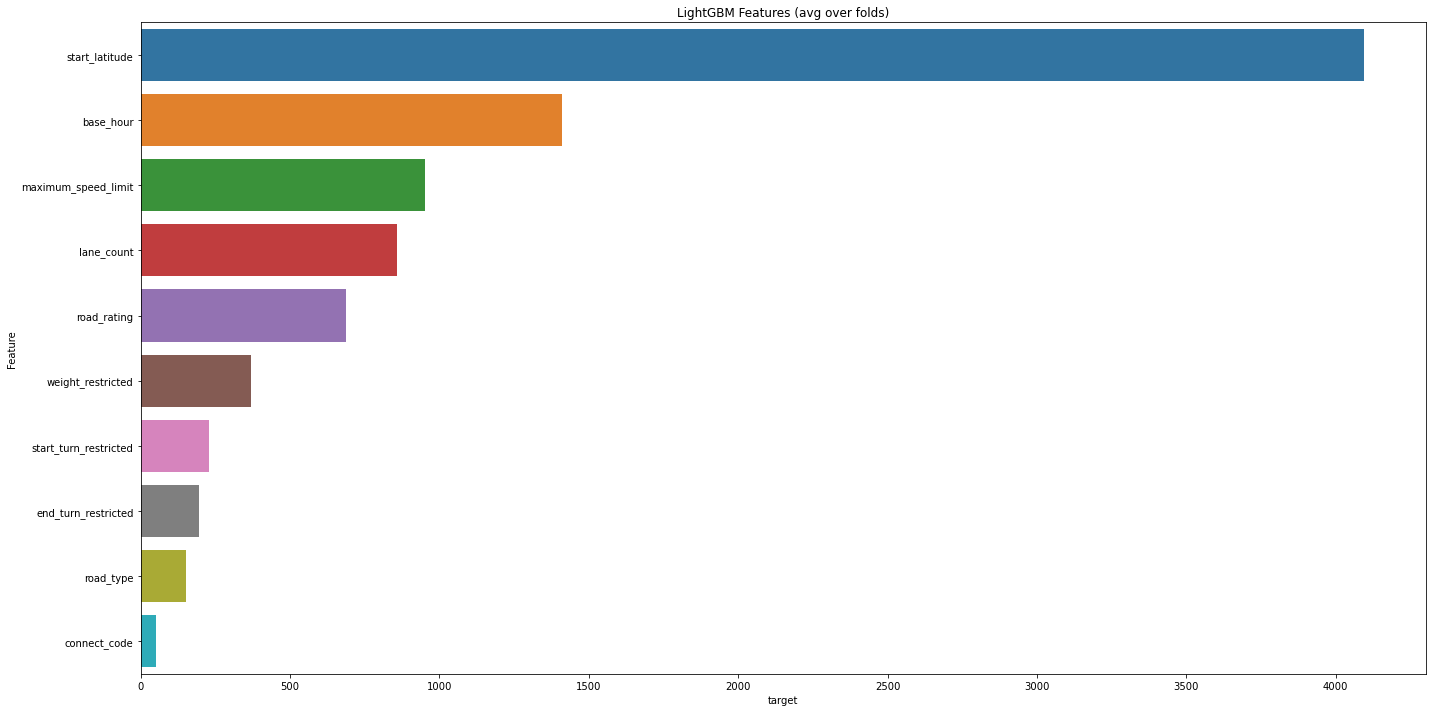

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(LR.feature_importances_,x_train.columns)), columns=['target','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="target", y="Feature", data=feature_imp.sort_values(by='target', ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [ ]:
mean_absolute_error(y_test, pred)

4.746064311708223

# Deep-learning

In [ ]:
from keras import models
from keras.layers import Dense
from tensorflow.keras.utils import plot_model

def build_model():
    model = keras.Sequential([
        Dense(64, input_shape=(13,), activation="relu"), # 입력은 13
        Dense(64, activation="relu"),
        Dense(1) # 출력은 확률값 하나만!
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics="mae")
    return model

model=build_model()
plot_model(model, show_shapes=True, show_layer_activations=True)

# submission

In [ ]:
sample_submission = pd.read_csv('./sample_submission.csv')

In [ ]:
pred = LR.predict(d_test)

In [ ]:
sample_submission['target'] = pred
sample_submission.to_csv("./submit.csv", index = False)
sample_submission

,id,target
0,TEST_000000,25.422560
1,TEST_000001,45.943264
2,TEST_000002,60.705882
3,TEST_000003,38.870285
4,TEST_000004,41.193630
...,...,...
291236,TEST_291236,47.611227
291237,TEST_291237,51.684429
291238,TEST_291238,22.066372
291239,TEST_291239,25.917014
